In [12]:
# -*- coding: utf-8 -*-
import re
import os
from unidecode import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

**Hàm tách từ và chuẩn hóa văn bản**

In [13]:
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

**Hàm tách từ**

In [14]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

**Đọc dữ liệu:** Lấy dữ liệu từ file consumer_complaints.csv


In [16]:
def Read_Data():    
    # Đọc dữ liệu từ file txt
    path = os.getcwd()
    with open(path + "\\Data\\Cau4\\Cau4_CleanData.txt", 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Lấy nội dung câu từ các dòng
    complaints = [line.split('=')[1].strip().strip('"') for line in lines]
    
    Data_sample = complaints
    
    # In ra một số mẫu dữ liệu
    print(Data_sample[:10])
    
    return Data_sample

**Hàm xây dựng Vector TF-IDF**

In [17]:
def Vectorize_TFIDF(corpus):
    # Xay dung vector dac trung TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,min_df=0.2, use_idf=True, ngram_range=(1,3))
    X = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names_out()
    print(X.shape)    
    return X, terms

**Hàm tìm số cụm K tối ưu bằng phương pháp Silhouette**

In [18]:
def Silhouette_Score(X,K_max):
    silhouette_scores = []
    for i in range(2, K_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        
    # Plot the Silhouette Scores    
    plt.plot(range(2, 11), silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.show()

**Hàm trình diễn dữ liệu**

In [19]:
def Presentation_Data(complaints,km,num_clusters):
    ranks = []
    for i in range(1, len(complaints)+1):
        ranks.append(i)
        
    clusters = km.labels_.tolist()
    complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
    frame = pd.DataFrame(complaints_data, index = [clusters] , columns =['rank', 'cluster'])

    # Thong ke so luong van ban o moi cum
    print("Numbers of Docs per cluster:")
    print(frame['cluster'].value_counts().sort_index())

    # Xac dinh 5 tu o gan tam cua moi cum nhat    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in complaints:
        allwords_stemmed = tokenize_and_stem(i)
        totalvocab_stemmed.extend(allwords_stemmed)
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
        
    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index =totalvocab_stemmed)

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print("Top 5 words closest to the cluster centers:")
    for i in range(num_clusters):
        print("Cluster %d words: " % i, end='')
        for ind in order_centroids[i, :6]:
            print(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=', ')
        print()        

    # Bieu dien tren bang do nhiet
    similarity_distance = 1 - cosine_similarity(X)

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(similarity_distance)
    xs, ys = pos[:, 0], pos[:, 1]

    # Thiet lap mau cho moi cum
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#2300FF', 6: '#FF88AE', 7: '#FFED88', 8: '#FF88FA', 9: '#88FF9F'}    

    # Thiet lap ten cho moi cum
    cluster_names=dict()
    for i in range(0,num_clusters):
        cluster_names[i]= "Cluster" + str(i)

    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
    groups = df.groupby('label')

    # Set up plot
    fig, ax = plt.subplots(figsize=(17, 9))
    for name, group in groups:
        ax.plot(group.x, group.y, marker="o", linestyle='',ms=20,label=cluster_names[name], color=cluster_colors[name],mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off',labelleft='off')
        
    ax.legend(numpoints=1)
    plt.show()

In [20]:
#######################################################################################
# Đọc dữ liệu
complaints=Read_Data()

['Giáo_dục chìa_khóa mở tương_lai giúp phát_triển bản_thân đóng_góp xã_hội', 'Thể_thao rèn_luyện sức_khoẻ mang lại tinh_thần đoàn_kết kỷ_luật tham_gia', 'Thực_hiện pháp_luật nghiêm_minh đảm_bảo xã_hội ổn_định công_bằng phát_triển bền_vững', 'Trẻ_em cần tiếp_cận giáo_dục chất_lượng cao phát_huy tiềm_năng', 'Luật bảo_vệ người_tiêu_dùng ngăn_chặn hành_vi gian_lận lừa_đảo giao_dịch', 'Chạy_bộ buổi_sáng hoạt_động đơn_giản lợi_ích sức_khoẻ thể_chất tinh_thần', 'Cơ_sở giáo_dục tăng_cường ứng_dụng công_nghệ thông_tin cải_thiện chất_lượng giảng_dạy học_tập', 'Luật giao_thông quy_định rõ hành_vi vi_phạm xử_lý nghiêm giảm thiểu tai_nạn bảo_vệ tính_mạng', 'Vận_động_viên duy_trì chế_độ tập_luyện khoa_học ăn_uống hợp_lý đạt thành_tích tốt', 'Học_sinh rèn_luyện kỹ_năng làm_việc nhóm chuẩn_bị tốt thách_thức cuộc_sống sự_nghiệp']


In [21]:
# Trích xuất đặc trưng văn bản
X, terms= Vectorize_TFIDF(complaints)

(20, 4)


**Giảm chiều cho dữ liệu bằng phương pháp TruncatedSVD**

In [23]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=4, random_state=42)
X = svd.fit_transform(X)

**Chấm điểm giá trị K của thuật toán K-Means - Phương pháp Silhouette Score (Điểm bóng)**

d:\22_Final\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
d:\22_Final\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


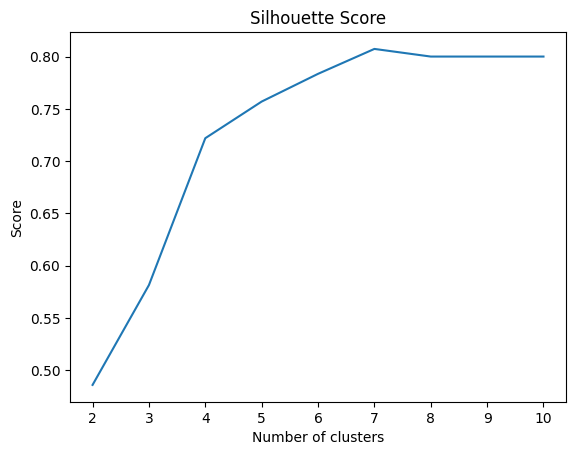

In [24]:
K_max=11
Silhouette_Score(X,K_max)

**Chạy thuật toán K-Means**
Dựa trên kết quả chấm điểm tối ưu giá trị K, ta quyết định chọn K=7 (num_clusters)

In [25]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters, n_init=7).fit(X)

Numbers of Docs per cluster:
cluster
0    4
1    8
2    2
3    2
4    2
5    1
6    1
Name: count, dtype: int64
Top 5 words closest to the cluster centers:
Cluster 0 words: giáo_dục, thể_thao, xã_hội, phát_triển, 
Cluster 1 words: giáo_dục, phát_triển, xã_hội, thể_thao, 
Cluster 2 words: phát_triển, giáo_dục, xã_hội, thể_thao, 
Cluster 3 words: thể_thao, phát_triển, giáo_dục, xã_hội, 
Cluster 4 words: phát_triển, giáo_dục, thể_thao, xã_hội, 
Cluster 5 words: giáo_dục, xã_hội, phát_triển, thể_thao, 
Cluster 6 words: phát_triển, giáo_dục, thể_thao, xã_hội, 


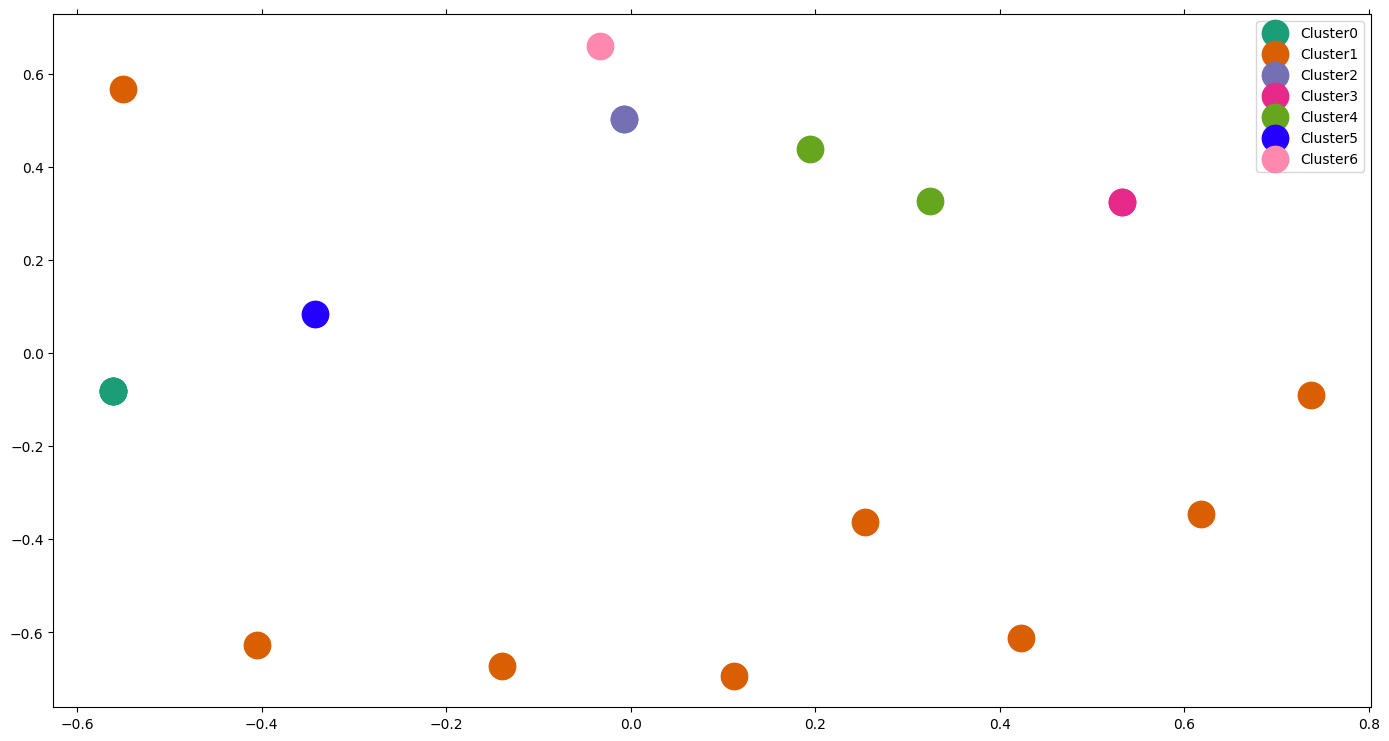

In [26]:
# Biểu diễn dữ liệu
Presentation_Data(complaints,km,num_clusters)